In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

In [3]:
all_configs = []
with open(CHECK_DIR / 'exp4.jsonl', 'r') as f:
    json_str = f.read()
    json_objs = json_str.split('}\n')
    for json_obj in json_objs:
        if json_obj:
            try:
                all_configs.append(json.loads(json_obj + '}'))
            except Exception as e:
                print(e)
                continue

In [5]:
all_configs

[{'data_dir': '/checkpoint/vivc/data/026cffe9-de15-4be9-8d8a-424cfdaaa596',
  'problem': 'binary-copy',
  'n_len': 32,
  'split_probas': 0.5,
  'n_data_per_len': 2048,
  'zipf_offset': 0,
  'zipf_coef': 0,
  'data_mix': 0.5,
  'emb_dim': 128,
  'emb_dropout': 0.1,
  'n_head': 1,
  'n_layer': 2,
  'n_epochs': 5000,
  'batch_size': 256,
  'learning_rate': 0.0003,
  'checkpoint_freq': 100,
  'overwrite_checkpoint': False,
  'load_checkpoint': False,
  'check_dir': '/checkpoint/vivc/models/026cffe9-de15-4be9-8d8a-424cfdaaa596',
  'full_eval': True,
  'eval_freq': 10},
 {'data_dir': '/checkpoint/vivc/data/686fb115-f1e7-426d-bd48-b705860513c5',
  'problem': 'parity',
  'n_len': 32,
  'split_probas': 0.5,
  'n_data_per_len': 2048,
  'zipf_offset': 0,
  'zipf_coef': 0,
  'data_mix': 0.5,
  'emb_dim': 128,
  'emb_dropout': 0.1,
  'n_head': 1,
  'n_layer': 2,
  'n_epochs': 5000,
  'batch_size': 256,
  'learning_rate': 0.0003,
  'checkpoint_freq': 100,
  'overwrite_checkpoint': False,
  'load_che

In [20]:
X = np.arange(4, 32)
Y = np.arange(8, 128)
Z = np.arange(0, 2001, 10)

Z1_parity = np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z2_parity = np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z3_parity = np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z4_parity = np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z1_nocot =  np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z2_nocot =  np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z3_nocot =  np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z4_nocot =  np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z1_copy =   np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z2_copy =   np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z3_copy =   np.full((len(X), len(Y), len(Z)), -1, dtype=float)
Z4_copy =   np.full((len(X), len(Y), len(Z)), -1, dtype=float)


for config in all_configs:
    data_dir = Path(config['data_dir'])
    problem = config['problem']
    n_len = config['n_len']
    split_probas = config['split_probas']
    n_data_per_len = config['n_data_per_len']
    zipf_offset = config['zipf_offset']
    zipf_coef = config['zipf_coef']
    emb_dim = config['emb_dim']
    emb_dropout = config['emb_dropout']
    n_head = config['n_head']
    n_layer = config['n_layer']
    n_epochs = config['n_epochs']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']
    check_dir = Path(config['check_dir'])
    eval_freq = config['eval_freq']
    checkpoint_freq = config['checkpoint_freq']
    overwrite_checkpoint = config['overwrite_checkpoint']
    load_checkpoint = config['load_checkpoint']

    # print(f"{n_len=}, {problem=}")

    if n_head != 1 or n_layer != 2:
        continue

    try:
        checkpoint = torch.load(check_dir / 'model_2000.pth')
    except Exception as e:
        print(e)
        print("problem with", problem, emb_dim, n_len)
        continue

    timestamps = checkpoint['timestamps']
    ind = timestamps != -1
    timestamps = timestamps[ind]

    meaning = checkpoint['meaning']
    evals = checkpoint['evals'][ind]

    eval_dim = evals.shape[1] // 2
    train_evals = evals[:, :eval_dim]
    test_evals = evals[:, eval_dim:]

    min_len = 4
    nd_meaning = np.array(meaning)
    res = np.empty((2, n_len + 1 - min_len), dtype=float)
    for i, eval_prefix in enumerate(['attn0_peaky_thres', 'attn1_peaky_thres']):
        for j, length in enumerate(range(min_len, n_len+1)):
            eval_name = f"{eval_prefix}_{length}"

            ind = np.argmax(np.array(meaning) == eval_name)

            train_res = train_evals[-1, ind]
            test_res = test_evals[-1, ind]
            res[i, j] = test_res

    train_acc = train_evals[:, min_len-1:n_len].mean(axis=1)
    test_acc = test_evals[:, min_len-1:n_len].mean(axis=1)
    # res = res.mean(axis=1)
    print(problem, res, check_dir)

    x = np.argmax(X == n_len)
    y = np.argmax(Y == emb_dim)
    try:
        if problem == 'parity':
            Z1_parity[x, y] = train_acc
            Z2_parity[x, y] = test_acc
            # Z3_parity[x, y] = res[0]
            # Z4_parity[x, y] = res[1]
        elif problem == 'no-cot':
            Z1_nocot[x, y] = train_acc
            Z2_nocot[x, y] = test_acc
            # Z3_nocot[x, y] = res[0]
            # Z4_nocot[x, y] = res[1]
        elif problem == 'binary-copy':
            Z1_copy[x, y] = train_acc
            Z2_copy[x, y] = test_acc
            # Z3_copy[x, y] = res[0]
            # Z4_copy[x, y] = res[1]
        else:
            break
    except Exception as e:
        print(e)

binary-copy [[1.         0.8        1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         0.95652174 0.95833333 1.         0.96153846 0.96296296
  0.96428571 1.         0.96666667 0.96774194 0.96875   ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]] /checkpoint/vivc/models/026cffe9-de15-4be9-8d8a-424cfdaaa596
parity [[1.         1.         1.         1.         1.         1.
  0.95097656 1.         1.         1.         0.92857143 1.
  1.         1.         1.         0.94736842 1.         0.95238095
  1.         1.         1.         1.         0.98050631 1.
  1.         0.98312904 0.98310547 0.96774194 0.87496948]
 [1.     

In [17]:
res

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.95097656, 1.        , 1.        , 1.        ,
        0.92857143, 1.        , 1.        , 1.        , 1.        ,
        0.94736842, 1.        , 0.95238095, 1.        , 1.        ,
        1.        , 1.        , 0.98050631, 1.        , 1.        ,
        0.98312904, 0.98310547, 0.96774194, 0.87496948],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.9       , 1.        , 1.        , 1.        ,
        0.92857143, 0.93333333, 0.875     , 0.94117647, 0.83333333,
        0.89473684, 0.9       , 0.85714286, 0.95454545, 0.91304348,
        0.91666667, 0.84      , 0.80769231, 0.88888889, 0.78571429,
        0.72413793, 0.83333333, 0.80645161, 0.78125   ]])

In [6]:
x, y = np.meshgrid(X, Y)

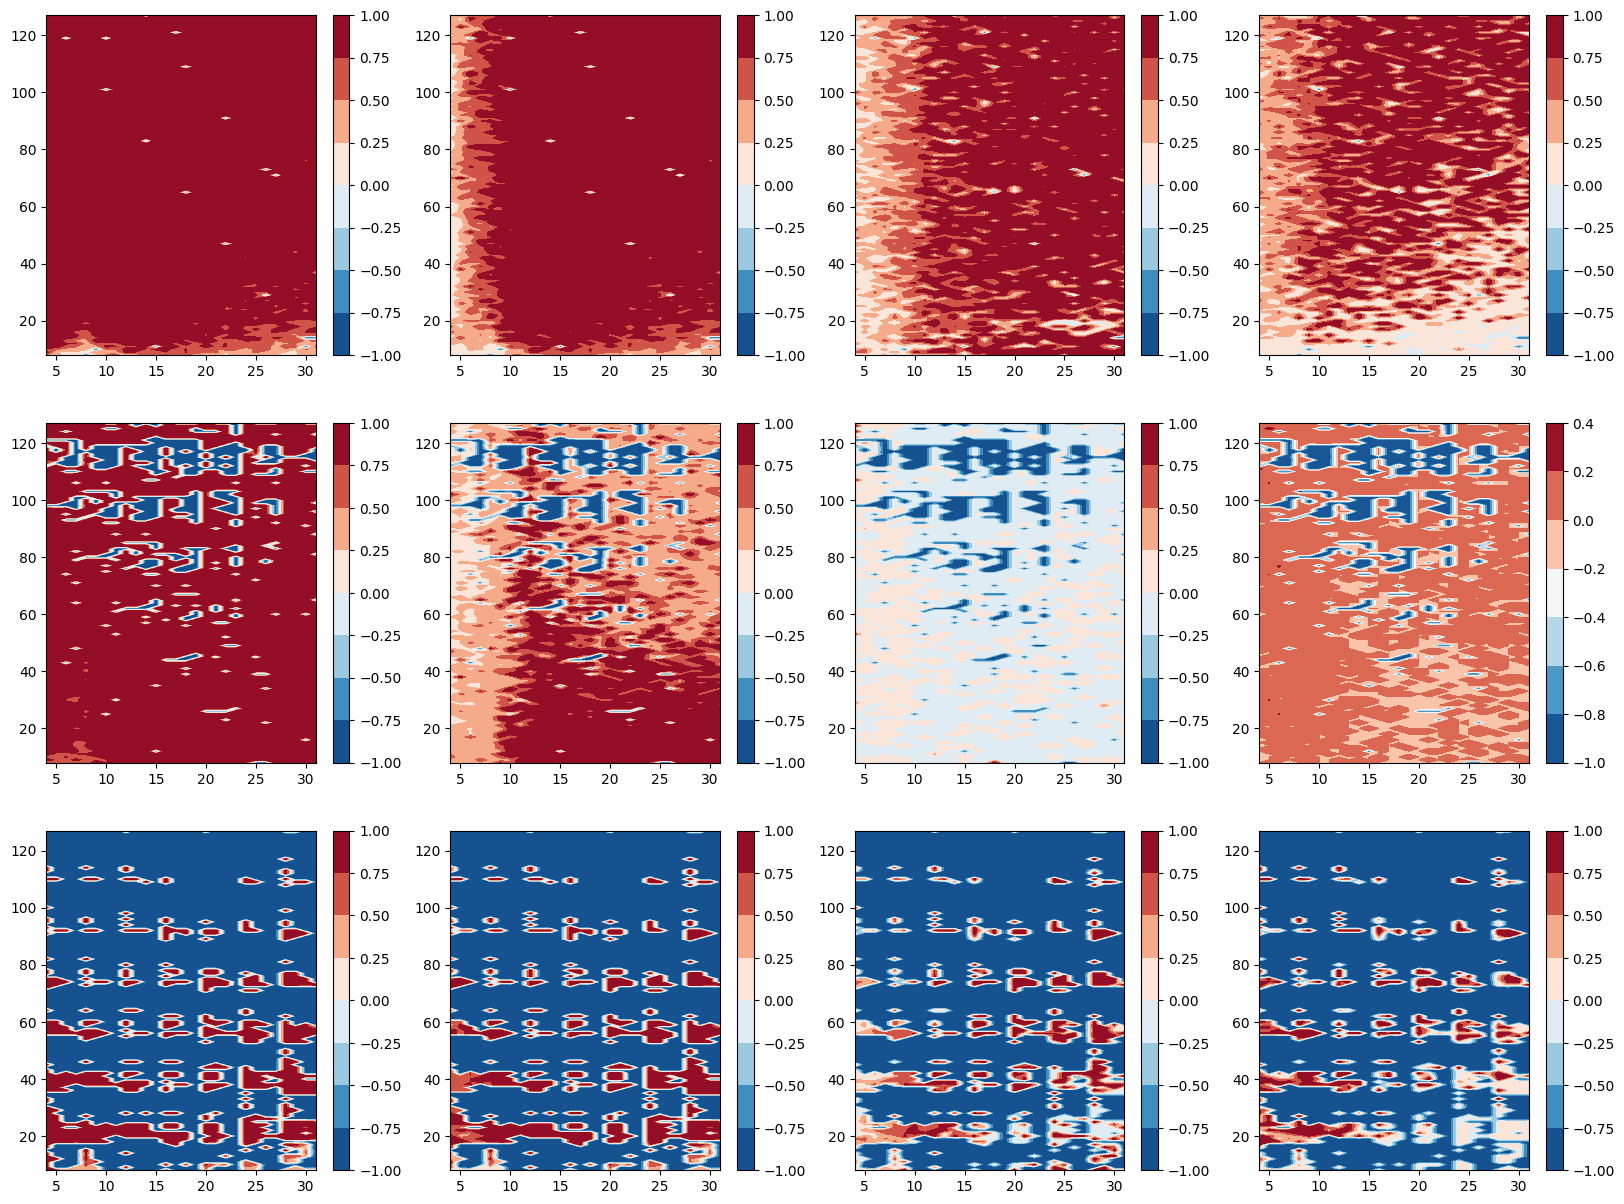

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
a00 = axes[0, 0].contourf(x, y, Z1_parity.T, cmap='RdBu_r')
a01 = axes[0, 1].contourf(x, y, Z2_parity.T, cmap='RdBu_r')
a02 = axes[0, 2].contourf(x, y, Z3_parity.T, cmap='RdBu_r')
a03 = axes[0, 3].contourf(x, y, Z4_parity.T, cmap='RdBu_r')
a10 = axes[1, 0].contourf(x, y, Z1_nocot.T, cmap='RdBu_r')
a11 = axes[1, 1].contourf(x, y, Z2_nocot.T, cmap='RdBu_r')
a12 = axes[1, 2].contourf(x, y, Z3_nocot.T, cmap='RdBu_r')
a13 = axes[1, 3].contourf(x, y, Z4_nocot.T, cmap='RdBu_r')
a20 = axes[2, 0].contourf(x, y, Z1_copy.T, cmap='RdBu_r')
a21 = axes[2, 1].contourf(x, y, Z2_copy.T, cmap='RdBu_r')
a22 = axes[2, 2].contourf(x, y, Z3_copy.T, cmap='RdBu_r')
a23 = axes[2, 3].contourf(x, y, Z4_copy.T, cmap='RdBu_r')
fig.colorbar(a00)
fig.colorbar(a01)
fig.colorbar(a02)
fig.colorbar(a03)
fig.colorbar(a10)
fig.colorbar(a11)
fig.colorbar(a12)
fig.colorbar(a13)
fig.colorbar(a20)
fig.colorbar(a21)
fig.colorbar(a22)
fig.colorbar(a23)